In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time


mockdata = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")



In [21]:
mask = np.where(mockdata[:,6] > 0)
mockdata[:,6][mask] = 1

(array([ 5400.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 32400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

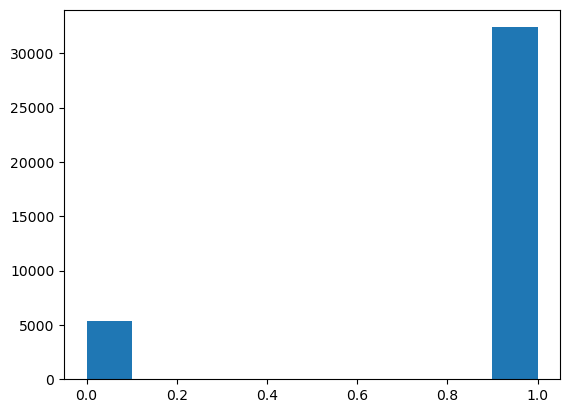

In [22]:
plt.hist(mockdata[:,6])

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BulgeStack(nn.Module):
    def __init__(self, pp_in, pp_out):
        super(BulgeStack, self).__init__()
        self.l1 = nn.Linear(pp_in, 10)
        self.l2 = nn.Linear(10, 20)
        self.l3 = nn.Linear(20, 10)
        self.l4 = nn.Linear(10, pp_out)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return x


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = BulgeStack(6, 6)
        self.fc2 = BulgeStack(6,6)
        self.fc3 = BulgeStack(6,6)
        self.fc4 = BulgeStack(6,2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


In [24]:
def train_model(device, trainingdata: torch.Tensor, trainingresult: torch.Tensor, epochs=10):
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss()  # Multiclass classification loss
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Move data to device
    x = trainingdata.float().to(device)
    y = trainingresult.long().to(device)  # Targets must be of type LongTensor

    # Debugging: Check input/output shapes
    print("Training data shape:", x.shape)
    print("Target shape:", y.shape)

    start_time = time.time()

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)  # Forward pass (logits)
        print("Model output shape:", outputs.shape)  # Debugging
        loss = criterion(outputs, y)  # Compute loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")  # Log loss
        loss.backward()
        optimizer.step()

    elapsed_time = time.time() - start_time
    print(f"Training completed on {device} in {elapsed_time:.2f} seconds")
    return model


In [25]:
# Prepare features and labels
features = mockdata[:, :6]  # First 6 columns for features
labels = mockdata[:, 6]     # 7th column for class labels (multiclass)

# Ensure labels are integers (already assumed to be 0 to 6)
labels = labels.astype(np.int64)  # Convert to int64 for PyTorch compatibility

print("Unique target classes:", np.unique(labels))


Unique target classes: [0 1]


In [26]:
print("\nTraining")

device = torch.device("cuda")

model = train_model(
    device,
    torch.from_numpy(features),
    torch.from_numpy(labels),
    epochs = 1000
)



Training
Training data shape: torch.Size([37800, 6])
Target shape: torch.Size([37800])
Model output shape: torch.Size([37800, 2])
Epoch 1/1000, Loss: 0.6790724992752075
Model output shape: torch.Size([37800, 2])
Epoch 2/1000, Loss: 0.6771942973136902
Model output shape: torch.Size([37800, 2])
Epoch 3/1000, Loss: 0.6753163933753967
Model output shape: torch.Size([37800, 2])
Epoch 4/1000, Loss: 0.6734618544578552
Model output shape: torch.Size([37800, 2])
Epoch 5/1000, Loss: 0.6716268062591553
Model output shape: torch.Size([37800, 2])
Epoch 6/1000, Loss: 0.6697887778282166
Model output shape: torch.Size([37800, 2])
Epoch 7/1000, Loss: 0.6679772734642029
Model output shape: torch.Size([37800, 2])
Epoch 8/1000, Loss: 0.6661728024482727
Model output shape: torch.Size([37800, 2])
Epoch 9/1000, Loss: 0.6643807291984558
Model output shape: torch.Size([37800, 2])
Epoch 10/1000, Loss: 0.6625997424125671
Model output shape: torch.Size([37800, 2])
Epoch 11/1000, Loss: 0.6608330607414246
Model ou

In [27]:
def plot_probability_distribution(model, feature_data, feature_3_idx=2, feature_4_idx=3, resolution=100, device='cuda'):
    """
    Plots the probability distribution in the plane of the third and fourth feature.

    Parameters:
        model: Trained PyTorch model.
        feature_data: Original feature data (to determine the range of features).
        feature_3_idx: Index of the third feature (default: 2).
        feature_4_idx: Index of the fourth feature (default: 3).
        resolution: Number of points along each axis in the grid (default: 100).
        device: Device to run the computation on ('cuda' or 'cpu').
    """
    # Transfer the model to the specified device
    model = model.to(device)

    # Determine the ranges for the third and fourth features
    feature_3_range = np.linspace(feature_data[:, feature_3_idx].min(), feature_data[:, feature_3_idx].max(), resolution)
    feature_4_range = np.linspace(feature_data[:, feature_4_idx].min(), feature_data[:, feature_4_idx].max(), resolution)

    # Create a mesh grid
    grid_x, grid_y = np.meshgrid(feature_3_range, feature_4_range)

    # Prepare input data for the model
    grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]  # Flatten grid
    num_features = feature_data.shape[1]
    
    # Fix other features to their mean values
    fixed_features = np.mean(feature_data, axis=0)
    input_data = np.tile(fixed_features, (grid_points.shape[0], 1))
    input_data[:, feature_3_idx] = grid_points[:, 0]
    input_data[:, feature_4_idx] = grid_points[:, 1]

    # Convert to PyTorch tensor and transfer to device
    input_tensor = torch.from_numpy(input_data).float().to(device)

    # Use the model to compute probabilities
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()  # Convert to probabilities and move to CPU for plotting

    # Reshape probabilities for plotting
    prob_class = [probabilities[:, 0].reshape(resolution, resolution),  # Example: probabilities for class 0
                probabilities[:, 1].reshape(resolution, resolution)] # Example: probabilities for class 0
                # probabilities[:, 2].reshape(resolution, resolution),  # Example: probabilities for class 0
                # probabilities[:, 3].reshape(resolution, resolution),  # Example: probabilities for class 0
                # probabilities[:, 4].reshape(resolution, resolution),  # Example: probabilities for class 0
                # probabilities[:, 5].reshape(resolution, resolution),  # Example: probabilities for class 0
                # probabilities[:, 6].reshape(resolution, resolution)]  # Example: probabilities for class 0
    # Plot the probability distribution
    # fig, ax = plt.subplots(3, 3, figsize=(8, 6),squeeze = False)
    # ax[0,0].contourf(grid_x, grid_y, prob_class_0, levels=50, cmap='viridis')
    # # plt.colorbar(label="Probability of Class 6")
    # plt.xlabel(f"Feature m1")
    # plt.ylabel(f"Feature m2")
    # plt.title("Probability Distribution for Class 6")
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.xlim([20, 800])
    # plt.ylim([2, 300])
    # plt.show()

    nx = 2
    ny = 1
    fig,ax =plt.subplots(ny, nx,squeeze=False, figsize = (10, 5), sharex=True, sharey=True)

    slices = np.array([[0, 1]])

    for ix in range(nx):
        for iy in range(ny):
            if slices[iy,ix] >= 0:
                mask = mockdata[:,6] == slices[iy,ix]
                
                
                ax[iy,ix].contourf(grid_x, grid_y, prob_class[slices[iy,ix]], levels=50, cmap='viridis')
                ax[iy,ix].scatter(mockdata[:,2][mask], mockdata[:,3][mask], s = 0.1, alpha = 0.5, color = 'tab:red')
                if (iy == ny-1):
                    ax[iy,ix].set_xlabel(r"$m_{1}$")
                if (ix == 0):
                    ax[iy,ix].set_ylabel(r"$m_{2}$")
                ax[iy,ix].loglog()
            ax[iy,ix].set_xlim([20, 800])
            ax[iy,ix].set_ylim([2, 300])
            ax[iy,ix].tick_params(axis="y",direction="in",which="both")
            ax[iy,ix].tick_params(axis="x",direction="in",which="both")
            ax[iy,ix].text(0.1,0.9, f"k={slices[iy,ix]}", transform=ax[iy,ix].transAxes, va= "top", ha ="left")

    
    fig.subplots_adjust(hspace = 0.05, wspace=0.05)






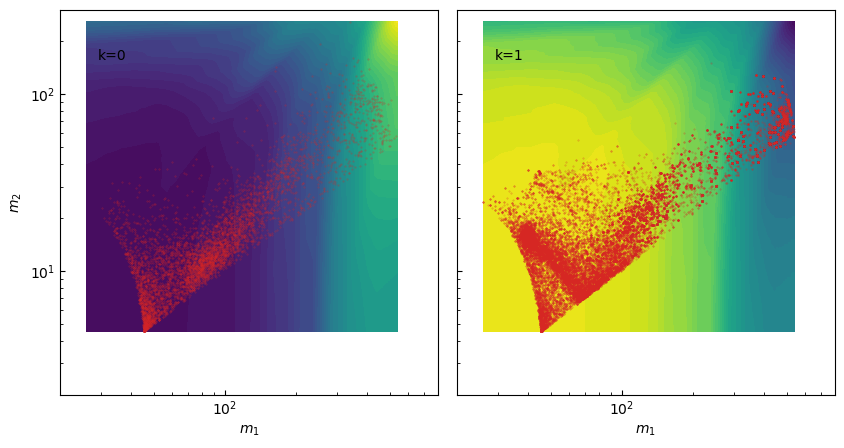

In [28]:
# Example usage
# features = mockdata[:, :6]  # First 6 columns as features

plot_probability_distribution(model, features, device='cuda')



